In [30]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage
from typing import Annotated, List
import operator
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.utilities import GoogleSerperAPIWrapper
import pprint


In [31]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")


In [32]:
llm = ChatGroq(model="gemma2-9b-it")

In [33]:
# import trafilatura

# def extract_article_trafilatura(url: str) -> str:
#     try:
#         downloaded = trafilatura.fetch_url(url)
#         if downloaded:
#             return trafilatura.extract(downloaded, include_comments=False, include_tables=False)
#         else:
#             return "Failed to download the webpage"
#     except Exception as e:
#         return f"Failed to extract article with trafilatura: {e}"
    
# #

In [44]:
def news(topic: str):
    search = GoogleSerperAPIWrapper(type="news", tbs="qdr:h24")
    results = search.results(topic)
    #pprint.pp(results)
    
    for news in results["news"]:
        for key in ['imageUrl', 'position', 'snippet']:
            if key in news:
                del news[key] 
        
        
    #pprint.pp(results)
    return results['news']


In [35]:
lst = news(topic="AI")
lst

[{'title': 'UMD Research Sends AI Safety to Market',
  'link': 'https://today.umd.edu/umd-research-sends-ai-safety-to-market',
  'snippet': 'Tech companies are racing to build the most powerful artificial intelligence (AI) models, but amid intense competition, safety issues like user privacy and...',
  'date': '2 hours ago',
  'source': 'Maryland Today'},
 {'title': 'Netflix’s Reed Hastings Gives $50 Million to Bowdoin for A.I. Program',
  'link': 'https://www.nytimes.com/2025/03/24/technology/reed-hastings-bowdoin-ai.html',
  'snippet': 'The Netflix co-founder Reed Hastings wants more researchers and students to ask deep questions about artificial intelligence and its potential to upend...',
  'date': '1 hour ago',
  'source': 'The New York Times'},
 {'title': 'As the Trump administration loosens AI rules, states look to regulate the technology',
  'link': 'https://virginiamercury.com/2025/03/24/as-the-trump-administration-loosens-ai-rules-states-look-to-regulate-the-technology/',
  '

In [ ]:
class Section(BaseModel):
    title: str = Field(
        description="A title of the news",
    )
    link: str = Field(
        description="A link to the news",
    )
    time_published: str = Field(
        description="A time when news published",
    )
    source: str = Field(
        description="A news chennel name",
    )
    # snippet: str = Field(
    #     description="News overview",
    # )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the AI news",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


In [59]:
orchestration_instruction = """
You are the Orchestrator Agent in a multi-agent AI system for curating and summarizing AI-related news.

You will receive the latest AI news scraped from the web in the form of list of dictionary. Each news includes:
- title
- link
- snippet
- date (time published)
- source

Your task is to:
1. Analyze each news item. 
3. Your task is to generate a well-organized outline (plan) for the given news information.
"""

worker_instruction = """
You are a Worker Agent in an AI news summarization system. 
Your goal is to present each news item with clarity, creativity, and professionalism.

Your responsibilities:

1. **News Type**: Clearly state the category (e.g., AI in Healthcare, AI Ethics).
2. **Title**: Assign a compelling, relevant title to the news.
3. **Source & Timestamp**: Mention the source and time of publication right under the title.
4. **Article Understanding**: Use the provided link to read and understand the article.
5. **Snippet**: Write a short, engaging snippet to help the reader decide whether to read the full article.
6. **Summary**: Provide a concise yet comprehensive 3-5 sentence summary that captures all key aspects.
7. **Analysis**: Reflect on the article's significance, relate it to past developments if relevant, and explain its potential future impact.
8. **Key Insights**: Include 2-3 bullet points highlighting important takeaways.
9. **Original Source**: End with the direct link to the article so users can explore further if interested.

Use clean **Markdown formatting** throughout for clear presentation.
"""

In [54]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    news_topic: str  # news topic
    sections: list[Section]  # List of news sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the news"""

    #print("Orchestrator is activated, here output will be lst of section: State")
    latest_news = news(state["news_topic"])
    print(latest_news)
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content=orchestration_instruction),
            HumanMessage(
                content=f"Here is the latest AI news: {latest_news}"
            ),
        ]
    )
    #print(state["topic"])
    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    #print("llm_call is activated, here output will be lst of section: WorkerState, section = ")

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content=worker_instruction),
            HumanMessage(
                content=f"Here is the news_title: {state['section'].title},\
                      news_link: {state['section'].link}, time_published: {state['section'].time_published},\
                          news_source: {state['section'].source}" # news_snippet: {state['section'].snippet}
            ),
        ]
    )

    #print(f"{state['section']},\n {type(state['section'])}")
    # Write the updated section to completed sections
    #print("section = \n", section)
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    #print("synthesizer is activated, here output will be lst of completed sections: State")

    # List of completed sections
    completed_sections = state["completed_sections"]
    #print("completed_sections",completed_sections)
    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    #print("completed_report_sections",completed_report_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    #print([s for s in state["sections"]])
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


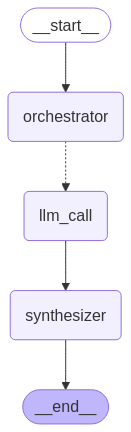

In [55]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

orchestrator_worker

In [56]:
# Invoke
state = orchestrator_worker.invoke({"news_topic": "AI"})

[{'title': 'AI-First', 'link': 'https://marketoonist.com/2025/03/ai-first.html', 'date': '21 minutes ago', 'source': 'Marketoonist | Tom Fishburne'}, {'title': 'UMD Research Sends AI Safety to Market', 'link': 'https://today.umd.edu/umd-research-sends-ai-safety-to-market', 'date': '2 hours ago', 'source': 'Maryland Today'}, {'title': 'Netflix’s Reed Hastings Gives $50 Million to Bowdoin for A.I. Program', 'link': 'https://www.nytimes.com/2025/03/24/technology/reed-hastings-bowdoin-ai.html', 'date': '1 hour ago', 'source': 'The New York Times'}, {'title': 'As the Trump administration loosens AI rules, states look to regulate the technology', 'link': 'https://virginiamercury.com/2025/03/24/as-the-trump-administration-loosens-ai-rules-states-look-to-regulate-the-technology/', 'date': '2 hours ago', 'source': 'Virginia Mercury'}, {'title': 'The evolution of AI in drug discovery: learning from history’s mistakes (Part 2)', 'link': 'https://www.drugtargetreview.com/article/157541/the-evoluti

In [57]:
state

{'news_topic': 'AI',
 'sections': [Section(title='AI-First', link='https://marketoonist.com/2025/03/ai-first.html', time_published='21 minutes ago', source='Marketoonist | Tom Fishburne', snippet=''),
  Section(title='UMD Research Sends AI Safety to Market', link='https://today.umd.edu/umd-research-sends-ai-safety-to-market', time_published='2 hours ago', source='Maryland Today', snippet=''),
  Section(title='Netflix’s Reed Hastings Gives $50 Million to Bowdoin for A.I. Program', link='https://www.nytimes.com/2025/03/24/technology/reed-hastings-bowdoin-ai.html', time_published='1 hour ago', source='The New York Times', snippet=''),
  Section(title='As the Trump administration loosens AI rules, states look to regulate the technology', link='https://virginiamercury.com/2025/03/24/as-the-trump-administration-loosens-ai-rules-states-look-to-regulate-the-technology/', time_published='2 hours ago', source='Virginia Mercury', snippet=''),
  Section(title='The evolution of AI in drug discovery

In [58]:
from IPython.display import Markdown
Markdown(state["final_report"])

## AI-First: The New Normal

**Source**: Marketoonist | Tom Fishburne 
**Timestamp**: 21 minutes ago

**Snippet**: 

In a world rapidly overtaken by AI, Marketoonist's Tom Fishburne envisions a future where the line between human and machine blurs. This insightful comic explores the impending shift towards "AI-First" businesses, highlighting the challenges and opportunities that lie ahead for marketers and businesses alike.

**Summary**:

Tom Fishburne's "AI-First" comic paints a vivid picture of a future where AI seamlessly integrates into every aspect of business.  It showcases the potential for AI to revolutionize marketing, customer service, and product development, but also warns of the risks associated with over-reliance on automation. The comic emphasizes the need for businesses to adapt and evolve alongside AI, emphasizing the importance of human creativity and critical thinking in navigating this new landscape. 

**Analysis**:

Fishburne's comic serves as a timely reminder of the transformative power of AI and its profound impact on the business world. It echoes recent trends in AI adoption across industries, highlighting the growing need for businesses to embrace AI-powered solutions. However, the comic also underscores the importance of striking a balance between automation and human ingenuity, reminding us that AI should augment, not replace, human capabilities.

**Key Insights**:

* **AI is rapidly changing the business landscape:** Businesses need to adapt and evolve to remain competitive.
* **Human skills remain essential:** Creativity, critical thinking, and emotional intelligence will continue to be valuable assets in an AI-driven world.
* **Ethical considerations are paramount:**  As AI becomes more integrated into our lives, it's crucial to ensure responsible and ethical development and deployment.

**Original Source**: https://marketoonist.com/2025/03/ai-first.html 




---

## UMD Researchers Develop AI Safety Framework for Commercial Use

**Maryland Today**
2 hours ago

**Snippet:**  A team of researchers at the University of Maryland has developed a groundbreaking AI safety framework designed to be readily implemented in commercial applications. This innovative approach could significantly impact the responsible development and deployment of AI technologies.

**Summary:**

University of Maryland researchers have made a significant advancement in AI safety with the development of a practical and adaptable framework. This framework, detailed in a recent paper, focuses on aligning AI systems with human values and ensuring their safe and ethical operation. The researchers emphasize the importance of incorporating safety considerations from the initial design stages of AI systems. This novel approach is designed to be easily integrated into existing commercial workflows, paving the way for wider adoption of responsible AI practices.

**Analysis:**

This research represents a crucial step towards addressing the growing concerns surrounding AI safety.  By providing a tangible and implementable framework, the researchers are bridging the gap between theoretical discussions on AI ethics and real-world application. This development builds upon previous efforts in AI safety research but distinguishes itself by its focus on practical solutions for commercial use.  The potential impact of this framework is significant, as it could influence the development and deployment of AI across various industries, leading to more trustworthy and beneficial AI systems.

**Key Insights:**

* **Practical AI Safety:** The framework offers concrete guidelines and tools for integrating safety considerations into AI development.
* **Commercial Applicability:**  Designed for easy implementation in existing commercial workflows, making it accessible to a wider range of organizations.
* **Human-Centric Approach:**  Emphasizes aligning AI systems with human values and ensuring ethical operation.

**Original Source:** https://today.umd.edu/umd-research-sends-ai-safety-to-market





---

## Netflix CEO Pledges Millions to Bowdoin College's AI Initiative 

**The New York Times**
* 1 hour ago

**Snippet:** Netflix co-founder Reed Hastings is making a significant investment in artificial intelligence education, donating $50 million to Bowdoin College to establish a groundbreaking AI program. 

**Summary:** 
Reed Hastings, CEO of Netflix, has donated $50 million to Bowdoin College to establish a new Artificial Intelligence (AI) program. This substantial contribution will fund research, development, and education initiatives focused on AI. Hastings, a long-time advocate for AI's potential, believes this program will equip students with the skills needed to navigate the rapidly evolving technological landscape. Bowdoin College intends to leverage this investment to become a leader in AI education and research, attracting top talent and fostering innovation in the field.

**Analysis:**

Hastings' generous donation signifies a growing trend of tech industry leaders investing in AI education. This move aligns with his previous philanthropic endeavors aimed at expanding access to quality education.  The partnership between Netflix and Bowdoin College has the potential to shape the future of AI by nurturing a new generation of AI experts and fostering a deeper understanding of the technology's societal impact.

**Key Insights:**

* Reed Hastings' $50 million donation to Bowdoin College highlights the increasing importance of AI education.
* The new AI program at Bowdoin College aims to become a leader in AI research and education.
* This partnership signifies a growing trend of tech industry investment in AI education and research.

**Original Source:** [https://www.nytimes.com/2025/03/24/technology/reed-hastings-bowdoin-ai.html](https://www.nytimes.com/2025/03/24/technology/reed-hastings-bowdoin-ai.html) 




---

## AI Ethics 

###  States Step In as Trump Administration Eases AI Regulations 
**Virginia Mercury** 
*2 hours ago*

**Snippet:** With the Trump administration relaxing federal oversight of artificial intelligence, several states are taking the initiative to establish their own regulations, raising concerns about a patchwork of rules and potential conflicts.

**Summary:** The Trump administration has recently announced plans to loosen federal regulations on the development and deployment of AI, citing concerns about stifling innovation. This move has prompted several states, including Virginia, to consider enacting their own AI-specific legislation. 

These state-level regulations aim to address ethical concerns surrounding AI, such as bias, transparency, and accountability, while also ensuring responsible development and deployment within their jurisdictions. This potential for a patchwork of state-level regulations raises questions about consistency and potential conflicts between different state rules.

**Analysis:** This development signifies a shift in the landscape of AI governance, moving away from a centralized federal approach towards a more decentralized system. While the Trump administration's rationale emphasizes fostering innovation, critics argue that loosening regulations could lead to unforeseen consequences and exacerbate existing ethical challenges. This trend towards state-level regulation reflects a growing awareness of the unique risks and opportunities presented by AI, prompting individual states to take proactive steps in shaping its development and deployment within their borders. 

**Key Insights:**

* The Trump administration's easing of AI regulations could lead to a fragmented regulatory landscape across the US.
* States are stepping up to fill the void left by federal inaction, aiming to establish their own ethical guidelines for AI development and deployment.
* This trend highlights the increasing importance of state-level policymaking in navigating the complex ethical and societal implications of AI.

**Original Source:** https://virginiamercury.com/2025/03/24/as-the-trump-administration-loosens-ai-rules-states-look-to-regulate-the-technology/ 




---

## The Evolution of AI in Drug Discovery: Learning from History's Mistakes (Part 2)

**Source**: Drug Target Review
**Timestamp**: 2 hours ago

**Snippet**: This insightful article delves into the ongoing evolution of AI in drug discovery, highlighting past challenges and potential solutions.  Learn how lessons learned from previous AI-driven endeavors are shaping a more robust and effective future for pharmaceutical research. 

**Summary**: 
The second part of this series explores the past limitations of AI in drug discovery, focusing on issues like biased data and over-reliance on narrow AI approaches.  The article argues that a shift towards more comprehensive, multi-modal AI systems, incorporating diverse data sources and human expertise, is crucial for overcoming these hurdles.  It emphasizes the importance of transparency and ethical considerations in AI-driven drug development.

**Analysis**:  This article provides a timely and crucial reflection on the trajectory of AI in drug discovery. Building upon the lessons learned from earlier attempts, it underscores the need for a more holistic and collaborative approach to AI implementation.  The emphasis on multi-modal AI and ethical considerations aligns with the growing recognition that responsible AI development requires a nuanced understanding of its limitations and potential biases.  This shift towards human-centered AI in drug discovery holds significant promise for accelerating the development of safer and more effective treatments.

**Key Insights**:
*  Past AI drug discovery efforts have suffered from limitations like biased data and narrow AI approaches.
*  A shift towards multi-modal AI systems, incorporating diverse data sources and human expertise, is crucial for progress.
*  Transparency and ethical considerations must be integrated into the development and deployment of AI in drug discovery.

**Original Source**: https://www.drugtargetreview.com/article/157541/the-evolution-of-ai-in-drug-discovery-learning-from-historys-mistakes-part-2/





---

## AI and the Future of Physics

**Source**: Physics World
**Timestamp**: 2 hours ago

**Snippet**:  Artificial intelligence is poised to revolutionize physics research, accelerating discoveries and tackling complex problems. This article explores how AI is already being used to analyze data, simulate experiments, and uncover new insights in various areas of physics.

**Summary**:

AI is rapidly changing the landscape of physics research, offering powerful tools to analyze vast datasets, simulate complex systems, and accelerate scientific discovery. From uncovering patterns in cosmic microwave background radiation to predicting the behavior of materials, AI algorithms are helping physicists push the boundaries of knowledge. This article highlights the growing role of AI in fields like particle physics, cosmology, and condensed matter physics, showcasing its potential to address longstanding questions and unlock new frontiers in our understanding of the universe.

**Analysis**: 

The use of AI in physics is still in its early stages, but its potential impact is immense. By automating tedious tasks and uncovering hidden patterns in data, AI frees up physicists to focus on more creative and conceptual work. This could lead to breakthroughs in areas like dark matter detection, quantum computing, and the unification of fundamental forces.  The article echoes similar trends seen in other scientific disciplines, demonstrating the transformative power of AI across the scientific landscape.

**Key Insights**:

* AI algorithms are being used to analyze massive datasets from experiments, revealing new insights and patterns.
* AI-powered simulations are allowing physicists to study complex systems and test theories in ways that were previously impossible.
* The integration of AI into physics research is accelerating the pace of discovery and opening up new avenues of exploration.

**Original Source**: https://physicsworld.com/a/ai-and-the-future-of-physics/ 




---

## Apple's AI Delays Spark Legal Trouble: False Advertising Allegation

**Source**: PYMNTS.com
**Timestamp**: 3 hours ago

**Snippet**: 

Apple's much-hyped advancements in artificial intelligence are facing a setback as a class-action lawsuit accuses the tech giant of misleading consumers with exaggerated claims about its AI capabilities.

**Summary**:

A class-action lawsuit filed against Apple alleges the company engaged in false advertising by promoting its AI features, such as Siri and image analysis, as more advanced than they actually are. The lawsuit claims Apple's delays in delivering promised AI functionalities have left users with incomplete and underwhelming experiences. Plaintiffs argue that Apple's marketing campaigns created unrealistic expectations and deceived consumers into purchasing products based on false promises. 

**Analysis**:

This lawsuit highlights the growing scrutiny surrounding AI development and marketing practices. As AI becomes increasingly integrated into everyday products, companies face pressure to deliver on their claims and avoid misleading consumers.  Apple's delays in rolling out its AI features could have significant financial and reputational consequences. This case may set a precedent for future litigation against companies that overpromise on AI capabilities.

**Key Insights**:

*  The lawsuit underscores the importance of transparency and accuracy in AI marketing. 
* It raises concerns about the potential for consumer deception in the rapidly evolving AI landscape.
* The outcome of this case could impact how companies develop and market AI-powered products.

**Original Source**: https://www.pymnts.com/apple/2025/apples-ai-delays-lead-to-false-advertising-lawsuit/ 





---

## AI Chip Maker FuriosaAI Rejects Meta's $800 Million Offer

**Source**: Yahoo Finance
**Timestamp**: 58 minutes ago

**Snippet**: 

In a surprising turn of events, AI chip startup FuriosaAI has turned down Meta's $800 million acquisition offer, opting to remain independent and pursue its own path in the burgeoning AI hardware market.

**Summary**: 

FuriosaAI, a promising player in the AI chip arena, has rejected Meta's substantial bid for the company. This decision comes after Meta, seeking to bolster its AI infrastructure, explored acquiring FuriosaAI's proprietary chip technology. Despite the lucrative offer, FuriosaAI has chosen to maintain its independence, signaling its confidence in its own growth trajectory and future prospects. The company aims to continue developing its high-performance AI chips, targeting a wide range of applications in fields like machine learning and deep learning.

**Analysis**:

This rejection highlights the intense competition for talent and technology in the AI chip sector. While Meta's offer represented a significant financial incentive, FuriosaAI's decision indicates a belief in its own potential to disrupt the market independently. This move could embolden other AI startups to resist acquisition offers and forge their own paths. The long-term implications remain to be seen, but this development underscores the growing importance of AI hardware and the fierce battle for dominance in this rapidly evolving field.

**Key Insights**:

* FuriosaAI's rejection of Meta's offer demonstrates the growing confidence of AI startups in their ability to compete independently.
* This decision highlights the intense competition for AI talent and technology, with prominent tech giants like Meta actively seeking to acquire promising startups.
* The future of AI hardware is likely to be characterized by a mix of established players and innovative startups, each vying for a share of the rapidly expanding market.

**Original Source**: https://finance.yahoo.com/news/ai-chip-makerfuriosaai-rejects-meta-102300919.html 




---

## AI in Software Development

**Source**: WIRED
**Timestamp**: 1 hour ago

**Snippet**:  Forget Hollywood's portrayal of AI taking over coding jobs.  This Wired article delves into the real-world applications of AI in software engineering, revealing how developers are leveraging these tools to boost efficiency and creativity.

**Summary**:  

Contrary to popular belief, AI isn't replacing software engineers but rather augmenting their capabilities. Developers are using AI-powered tools for tasks like code completion, bug detection, and documentation generation, freeing up time for more complex and creative problem-solving.  While some concerns exist about job displacement, the article highlights how AI is ultimately creating new opportunities and reshaping the software development landscape.

**Analysis**: This article provides a nuanced perspective on the impact of AI in software development. It dispels myths about AI replacing human coders and instead showcases its potential to enhance productivity and innovation. The rise of AI-powered coding tools aligns with the broader trend of automation in various industries, prompting a necessary discussion about the evolving role of human workers in the face of technological advancements.

**Key Insights**:

*  AI is primarily used as a productivity booster for software engineers, not a replacement.
*  AI tools can streamline repetitive tasks, allowing developers to focus on more strategic aspects of coding.
*  The integration of AI in software development is likely to create new job roles and opportunities in the future.

**Original Source**: https://www.wired.com/story/how-software-engineers-coders-actually-use-ai/ 




---

## AI Chatter Hits Record on European Earnings Calls 

**Source**: Insurance Journal 
**Timestamp**: 2 hours ago

**Snippet**:  European companies across all sectors are increasingly mentioning AI during earnings calls, signaling a growing awareness and adoption of the technology.  This surge in AI chatter raises questions about the potential impact of AI on European businesses and the wider economy.  

**Summary**:  The latest data reveals a record number of mentions of artificial intelligence (AI) during earnings calls by European companies.  This trend is observed across diverse sectors, including insurance, finance, and technology.  Analysts suggest this surge signifies the increasing integration of AI into business operations and strategic planning. The focus on AI reflects a global shift towards leveraging its capabilities for improved efficiency, innovation, and competitive advantage.  

**Analysis**: This trend of AI-centric conversation in European earnings calls is not surprising, given the rapid advancements and increasing accessibility of AI technologies. It builds upon previous years' discussions around digital transformation and highlights Europe's proactive approach to embracing AI. The sustained focus on AI suggests a long-term commitment to its development and implementation, potentially leading to significant economic and societal transformations in the coming years.

**Key Insights**: 
* AI is becoming a core topic in European business strategy, with companies actively discussing its impact and integration.
* The surge in AI mentions across diverse sectors indicates its broad applicability and potential to revolutionize various industries.
* This trend suggests a future where AI plays a central role in driving innovation, efficiency, and growth in the European economy.

**Original Source**: https://www.insurancejournal.com/news/international/2025/03/24/816821.htm 


